## Product Name: Apple Airpods Pro (1st Gen)
## Group Number: 8
## Members:
1. **Soham Pal - B2024117**
2. Manas M Pai - B2024093
3. Jeemoni Saikia - B2024091
4. Aditya Aggarwal - B2024064
5. Satyam Himanshu - B2024111
6. Surya Sai Sampath - B2024119
7. Preksha Sharma - B2024102

In [58]:
#importing libraries
import re
import nltk
import emoji
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import string
import warnings
warnings.filterwarnings('ignore')

In [59]:
review_df = pd.read_excel("AirPods Pro  scrapped.xlsx", index_col=False)
review_df.head()

,Date,Name,Rating (Out of 5),Verified Purchase?,Review,Liked,Disliked
0,"Nov 16, 2024",WalmartCustomer,5,Verified Purchase,Walmart please change your policies to allow p...,-2,0
1,"May 13, 2024",Boworn,5,Verified Purchase,When I ordered for the first time The system s...,-99,-9
2,"Mar 2, 2024",Chase,5,Verified Purchase,One of my most favorite parts of these is the ...,-112,-2
3,"Dec 4, 2024",Mary,5,Seller Verified Purchase,I gifted these to my husband for his birthday ...,-1,0
4,"Oct 22, 2024",Andria,5,Seller Verified Purchase,"Very good, they start and stop music without m...",-1,0


In [60]:
review_df.shape

(23744, 7)

In [61]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import re
import random

def convert_to_date(date_str):
    try:
        # Case 1: Direct date conversion
        return datetime.strptime(date_str, "%b %d, %Y").strftime("%Y-%m-%d")
    except ValueError:
        pass

    # Case 2: Relative date conversion (e.g., "1 year ago", "7 months ago", "12 hours ago")
    match = re.match(r"(\d+) (\w+) ago", date_str)
    if match:
        num, unit = int(match.group(1)), match.group(2)
        today = datetime.today()

        if "month" in unit:
            return (today - relativedelta(months=num)).strftime("%Y-%m-%d")
        elif "day" in unit:
            return (today - timedelta(days=num)).strftime("%Y-%m-%d")
        elif "hour" in unit:
            return (today - timedelta(hours=num)).strftime("%Y-%m-%d")  # Keeping only date
        elif "week" in unit:
            return (today - timedelta(weeks=num)).strftime("%Y-%m-%d")
        elif "year" in unit:
            # Pick a random date in the past year
            random_days = random.randint(1, 365)
            return (today - timedelta(days=random_days)).strftime("%Y-%m-%d")

    return "Invalid date format"

In [62]:
review_df["Date"] = review_df["Date"].apply(convert_to_date) 

In [63]:
review_df["Date"]

0        2024-11-16
1        2024-05-13
2        2024-03-02
3        2024-12-04
4        2024-10-22
            ...    
23739    2024-09-20
23740    2024-07-02
23741    2024-08-02
23742    2024-05-02
23743    2024-09-26
Name: Date, Length: 23744, dtype: object

In [64]:
review_df["Liked"] = review_df["Liked"].abs()
review_df["Disliked"] = review_df["Disliked"].abs()
review_df.head()

,Date,Name,Rating (Out of 5),Verified Purchase?,Review,Liked,Disliked
0,2024-11-16,WalmartCustomer,5,Verified Purchase,Walmart please change your policies to allow p...,2,0
1,2024-05-13,Boworn,5,Verified Purchase,When I ordered for the first time The system s...,99,9
2,2024-03-02,Chase,5,Verified Purchase,One of my most favorite parts of these is the ...,112,2
3,2024-12-04,Mary,5,Seller Verified Purchase,I gifted these to my husband for his birthday ...,1,0
4,2024-10-22,Andria,5,Seller Verified Purchase,"Very good, they start and stop music without m...",1,0


In [65]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
VERB_CODES = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}

In [66]:
# Ensure "Review" column is a string and drop extra columns
review_df = review_df.loc[:, ~review_df.columns.str.contains('^Unnamed')]
review_df["Review"] = review_df["Review"].astype(str)

In [67]:
# Download necessary NLTK components
nltk.download('punkt')
nltk.download('stopwords')

# Precompile regex patterns
url_pattern = re.compile(r'https?://\S+|www\.\S+')
num_pattern = re.compile(r"\b\d+\b")
html_pattern = re.compile(r'<.*?>+')
emoji_pattern = re.compile("["  
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

[nltk_data] Downloading package punkt to C:\Users\SOHAM
[nltk_data]     PAL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\SOHAM
[nltk_data]     PAL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [68]:
# function for cleaning the sentences
def preprocess_sentences(text):
    text = text.lower()
    text = re.sub(r'flipkart|walmart|bestbuy|apple|airpod|pro|airpods|pod|pods', '', text)    #remove ecommerce websites and product name
    text = url_pattern.sub('', text)  # Remove URLs
    text = num_pattern.sub('', text)  # Remove numbers
    text = html_pattern.sub('', text)  # Remove HTML tags
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = emoji_pattern.sub('', text)  # Remove emojis
    # removing short form:

    text=re.sub("isn't|isnt",'is not',text)
    text=re.sub("didn't|didnt",'did not',text)
    text=re.sub("he's",'he is',text)
    text=re.sub("wasn't",'was not',text)
    text=re.sub("there's",'there is',text)
    text=re.sub("couldn't",'could not',text)
    text=re.sub("won't",'will not',text)
    text=re.sub("they're",'they are',text)
    text=re.sub("she's",'she is',text)
    text=re.sub("There's",'there is',text)
    text=re.sub("wouldn't",'would not',text)
    text=re.sub("haven't",'have not',text)
    text=re.sub("That's",'That is',text)
    text=re.sub("you've",'you have',text)
    text=re.sub("He's",'He is',text)
    text=re.sub("what's",'what is',text)
    text=re.sub("weren't",'were not',text)
    text=re.sub("we're",'we are',text)
    text=re.sub("hasn't",'has not',text)
    text=re.sub("you'd",'you would',text)
    text=re.sub("shouldn't",'should not',text)
    text=re.sub("let's",'let us',text)
    text=re.sub("they've",'they have',text)
    text=re.sub("You'll",'You will',text)
    text=re.sub("i'm",'i am',text)
    text=re.sub("we've",'we have',text)
    text=re.sub("it's",'it is',text)
    text=re.sub("don't",'do not',text)
    text=re.sub("that´s",'that is',text)
    text=re.sub("I´m",'I am',text)
    text=re.sub("it’s",'it is',text)
    text=re.sub("she´s",'she is',text)
    text=re.sub("he’s'",'he is',text)
    text=re.sub('I’m','I am',text)
    text=re.sub('I’d','I did',text)
    text=re.sub("he’s'",'he is',text)
    text=re.sub('there’s','there is',text)
    text = text.strip()  

    return text

In [69]:
# Apply cleaning
review_df["Cleaned_Review"] = review_df["Review"].apply(preprocess_sentences)

In [70]:
review_df

,Date,Name,Rating (Out of 5),Verified Purchase?,Review,Liked,Disliked,Cleaned_Review
0,2024-11-16,WalmartCustomer,5,Verified Purchase,Walmart please change your policies to allow p...,2,0,please change your policies to allow people to...
1,2024-05-13,Boworn,5,Verified Purchase,When I ordered for the first time The system s...,99,9,when i ordered for the first time the system s...
2,2024-03-02,Chase,5,Verified Purchase,One of my most favorite parts of these is the ...,112,2,one of my most favorite parts of these is the ...
3,2024-12-04,Mary,5,Seller Verified Purchase,I gifted these to my husband for his birthday ...,1,0,i gifted these to my husband for his birthday ...
4,2024-10-22,Andria,5,Seller Verified Purchase,"Very good, they start and stop music without m...",1,0,very good they start and stop music without ma...
...,...,...,...,...,...,...,...,...
23739,2024-09-20,Safetybob,1,NaN,"a second scam, insulting that you are not awar...",0,0,a second scam insulting that you are not aware...
23740,2024-07-02,Yatusabe,1,NaN,I have already had 2 pairs and both of the had...,18,130,i have already had pairs and both of the had ...
23741,2024-08-02,Solo92,1,NaN,They always fall off if you are runing or work...,0,0,they always fall off if you are runing or workout
23742,2024-05-02,user428082,1,NaN,It was fake AirPods. Charger is android and do...,1,8,it was fake s charger is android and doesnâ€™t...


## Phase 1: Sentiment Analysis to understand overall sentiment of the product

In [71]:
#nltk.download('vader_lexicon')
from textblob import TextBlob

#sia = SentimentIntensityAnalyzer()
review_df['sentiment_score'] = review_df['Cleaned_Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
review_df['sentiment'] = review_df['sentiment_score'].apply(lambda x: 'positive' if x > 0.2 else 'negative')

In [72]:
review_df

,Date,Name,Rating (Out of 5),Verified Purchase?,Review,Liked,Disliked,Cleaned_Review,sentiment_score,sentiment
0,2024-11-16,WalmartCustomer,5,Verified Purchase,Walmart please change your policies to allow p...,2,0,please change your policies to allow people to...,0.000000,negative
1,2024-05-13,Boworn,5,Verified Purchase,When I ordered for the first time The system s...,99,9,when i ordered for the first time the system s...,0.131818,negative
2,2024-03-02,Chase,5,Verified Purchase,One of my most favorite parts of these is the ...,112,2,one of my most favorite parts of these is the ...,0.337179,positive
3,2024-12-04,Mary,5,Seller Verified Purchase,I gifted these to my husband for his birthday ...,1,0,i gifted these to my husband for his birthday ...,0.400000,positive
4,2024-10-22,Andria,5,Seller Verified Purchase,"Very good, they start and stop music without m...",1,0,very good they start and stop music without ma...,0.487143,positive
...,...,...,...,...,...,...,...,...,...,...
23739,2024-09-20,Safetybob,1,NaN,"a second scam, insulting that you are not awar...",0,0,a second scam insulting that you are not aware...,-0.375000,negative
23740,2024-07-02,Yatusabe,1,NaN,I have already had 2 pairs and both of the had...,18,130,i have already had pairs and both of the had ...,0.200000,negative
23741,2024-08-02,Solo92,1,NaN,They always fall off if you are runing or work...,0,0,they always fall off if you are runing or workout,0.000000,negative
23742,2024-05-02,user428082,1,NaN,It was fake AirPods. Charger is android and do...,1,8,it was fake s charger is android and doesnâ€™t...,-0.500000,negative


In [73]:
review_df['sentiment'].value_counts()

sentiment
positive    19721
negative     4023
Name: count, dtype: int64

In [74]:
def process(text):
    words = nltk.word_tokenize(text)
    tags = nltk.pos_tag(words)  # Batch POS tagging

    temp_sent = [
        lemmatizer.lemmatize(word, 'v') if tag in VERB_CODES else lemmatizer.lemmatize(word)   #lemmatization - converting words to their base form
        for word, tag in tags if word not in stop_words and word.isalpha() and len(word) > 2
    ]

    return ' '.join(temp_sent)
review_df["Processed_review"] = review_df["Cleaned_Review"].apply(process)

In [75]:
review_df.head()

,Date,Name,Rating (Out of 5),Verified Purchase?,Review,Liked,Disliked,Cleaned_Review,sentiment_score,sentiment,Processed_review
0,2024-11-16,WalmartCustomer,5,Verified Purchase,Walmart please change your policies to allow p...,2,0,please change your policies to allow people to...,0.000000,negative,please change policy allow people pickup item ...
1,2024-05-13,Boworn,5,Verified Purchase,When I ordered for the first time The system s...,99,9,when i ordered for the first time the system s...,0.131818,negative,order first time system say ship wait system s...
2,2024-03-02,Chase,5,Verified Purchase,One of my most favorite parts of these is the ...,112,2,one of my most favorite parts of these is the ...,0.337179,positive,one favorite part transparency mode allow hear...
3,2024-12-04,Mary,5,Seller Verified Purchase,I gifted these to my husband for his birthday ...,1,0,i gifted these to my husband for his birthday ...,0.400000,positive,gift husband birthday say amaze he try many di...
4,2024-10-22,Andria,5,Seller Verified Purchase,"Very good, they start and stop music without m...",1,0,very good they start and stop music without ma...,0.487143,positive,good start stop music without make obvious the...


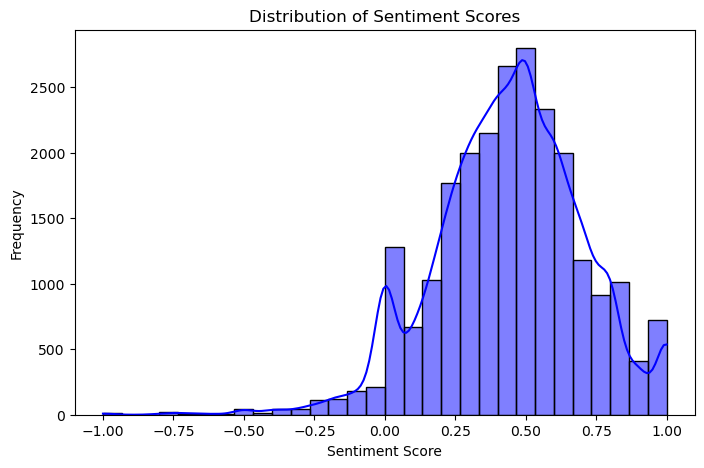

In [76]:
import numpy as np
from wordcloud import WordCloud

# Sentiment Distribution
plt.figure(figsize=(8, 5))
sns.histplot(review_df['sentiment_score'], bins=30, kde=True, color='blue')
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

In [77]:
from collections import Counter
cnt = Counter()
for text in review_df["Processed_review"].values:
    for word in text.split():
        cnt[word] += 1
cnt.most_common(10)
temp = pd.DataFrame(cnt.most_common(10))
temp.columns=['word', 'count']
temp

,word,count
0,great,8723
1,sound,8474
2,noise,6520
3,love,6095
4,quality,5255
5,good,4780
6,best,4236
7,work,4011
8,ear,3965
9,duct,3791


In [78]:
# Remove the most frequent words:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])
review_df["Processed_review"] = review_df["Processed_review"].apply(lambda text: remove_freqwords(text))
review_df.head()

,Date,Name,Rating (Out of 5),Verified Purchase?,Review,Liked,Disliked,Cleaned_Review,sentiment_score,sentiment,Processed_review
0,2024-11-16,WalmartCustomer,5,Verified Purchase,Walmart please change your policies to allow p...,2,0,please change your policies to allow people to...,0.000000,negative,please change policy allow people pickup item ...
1,2024-05-13,Boworn,5,Verified Purchase,When I ordered for the first time The system s...,99,9,when i ordered for the first time the system s...,0.131818,negative,order first time system say ship wait system s...
2,2024-03-02,Chase,5,Verified Purchase,One of my most favorite parts of these is the ...,112,2,one of my most favorite parts of these is the ...,0.337179,positive,one favorite part transparency mode allow hear...
3,2024-12-04,Mary,5,Seller Verified Purchase,I gifted these to my husband for his birthday ...,1,0,i gifted these to my husband for his birthday ...,0.400000,positive,gift husband birthday say amaze he try many di...
4,2024-10-22,Andria,5,Seller Verified Purchase,"Very good, they start and stop music without m...",1,0,very good they start and stop music without ma...,0.487143,positive,start stop music without make obvious theyre c...


In [79]:
# Topic Modeling (Positive & Negative Reviews)
def topic_modeling(reviews, num_topics=5, vocab_size=100):
    vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english', max_features=vocab_size) 
    tfidf_matrix = vectorizer.fit_transform(reviews)
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    topics = lda.fit_transform(tfidf_matrix)
    return lda, vectorizer, tfidf_matrix

In [ ]:
vocab_sizes = [100, 250, 500, 1000]
n_top_words = 10
#positive reviews
pos_reviews = review_df[review_df['sentiment'] == 'positive']['Processed_review']
for vocab_size in vocab_sizes:
    print(f"\nUsing vocab size: {vocab_size}")
    pos_lda, pos_vectorizer, pos_tfidf_matrix = topic_modeling(pos_reviews, vocab_size=vocab_size)
    pos_vocab = pos_vectorizer.get_feature_names_out()
    
    for topic_idx, topic in enumerate(pos_lda.components_):
        top_words = [pos_vocab[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")


Using vocab size: 100
Topic #1: buy, purchase, recommend, nice, amazing, happy, gift, definitely, son, item
Topic #2: battery, use, life, comfortable, earbuds, perfect, fit, time, charge, day
Topic #3: excellent, easy, phone, music, fast, connect, recommend, hear, use, highly
Topic #4: better, pair, gen, upgrade, service, air, new, far, generation, way
Topic #5: cancellation, amaze, headphone, feature, price, awesome, really, cancel, worth, like

Using vocab size: 250
Topic #1: earbuds, gen, upgrade, audio, cancellation, better, feature, generation, iphone, definitely
Topic #2: better, fit, comfortable, like, nice, stay, fall, really, size, come
Topic #3: battery, excellent, life, cancellation, use, music, amaze, awesome, feature, hear
Topic #4: gift, purchase, pair, happy, perfect, headphone, buy, really, son, daughter
Topic #5: buy, price, recommend, easy, service, amazing, highly, worth, excellent, fast

Using vocab size: 500
Topic #1: recommend, use, easy, headphone, pair, highly,

## 🔍 Topic Modeling Insights (Positive Reviews)
1️⃣ 🎁 Purchase & Gifting
- Customers frequently mention buying AirPods as gifts for family members, including children and spouses.
- Insight: AirPods are popular for holiday and special occasion gifting, making them a great product for seasonal promotions.

2️⃣ 🔋 Battery Life & Charging
- Many reviews highlight long battery life and fast charging as key advantages.
- Insight: Battery performance is a crucial factor, and emphasizing all-day usage & quick charging can attract more buyers.

3️⃣ 🎧 Noise Cancellation & Audio Quality
- Users appreciate the clear audio and effective noise cancellation, making AirPods ideal for travel and work.
- Insight: Positioning AirPods as premium audio devices with superior noise-canceling features can appeal to audiophiles and professionals.

4️⃣ 👌 Comfort & Fit
- A major reason for satisfaction is the comfortable and secure fit, especially for workouts and long-term use.
- Insight: Marketing should emphasize ergonomic design and comfort, targeting active users.

## Minimum Vocabulary Size for Best Topic Identification
Observations:

- 100 words → Too broad, many generic terms like "nice", "amazing".
- 250 words → Balanced, retains key themes without excessive generalization.
- 500 words → Captures nuanced features like "battery life" & "upgrade".
- 1000 words → Slight overfitting, with some words becoming repetitive.

**✅ Recommended Minimum Vocabulary Size: 250-500 - for an effective analysis and deeper topic differentiation

In [138]:
# Vectorize the positive reviews
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
X = vectorizer.fit_transform(pos_reviews)

# Apply KMeans Clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Assign the cluster labels to the dataframe for positive sentiment reviews
review_df.loc[review_df['sentiment'] == "positive", 'cluster'] = kmeans.labels_

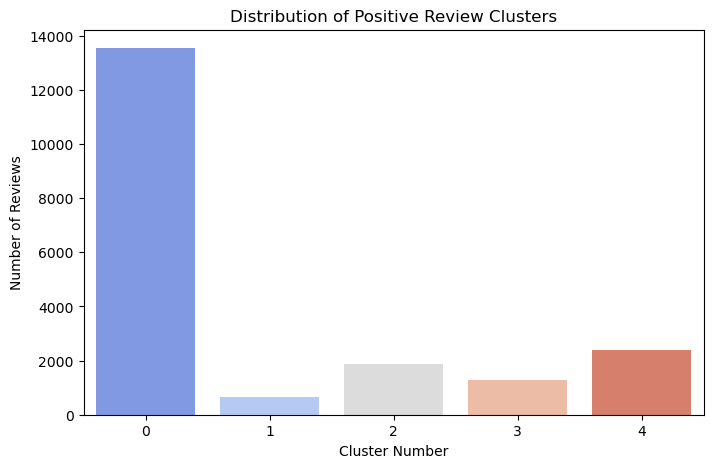

In [139]:
# Drop rows with NaN values in the 'cluster' column
df1 = review_df.copy() 
df1 = df1.dropna(subset=['cluster'])

# Now try the plot again
plt.figure(figsize=(8, 5))
sns.countplot(x=df1['cluster'].astype(int), palette='coolwarm')
plt.title("Distribution of Positive Review Clusters")
plt.xlabel("Cluster Number")
plt.ylabel("Number of Reviews")
plt.show()

In [140]:
# Display Cluster Keywords
feature_names = vectorizer.get_feature_names_out()
for cluster_num in range(num_clusters):
    print(f"Cluster {cluster_num} Keywords:")
    print(" ".join([feature_names[i] for i in np.argsort(kmeans.cluster_centers_[cluster_num])[-10:]]))
    print()

Cluster 0 Keywords:
easy comfortable amaze feature fit price better excellent use buy

Cluster 1 Keywords:
husband wife purchase perfect daughter happy son buy christmas gift

Cluster 2 Keywords:
headphone fit noice awesome better really excellent amaze feature cancellation

Cluster 3 Keywords:
amaze use cancellation really headphone excellent buy definitely highly recommend

Cluster 4 Keywords:
easy make happy use fit buy really perfect like purchase



## 📌 Cluster Analysis Insights (Positive Reviews)
- Cluster 0️⃣ Ease of Use & Comfort: Majority find AirPods easy to use & comfortable.

- Cluster 1️⃣ Gifting & Family Use: AirPods are popular as gifts, especially for family members.

- Cluster 2️⃣ Audio Quality & Noise Cancellation: Noise cancellation is a key reason for positive reviews.

- Cluster 3️⃣ Satisfaction & Performance: Customers highly recommend AirPods due to performance.

- Cluster 4️⃣ General User Experience: Overall, fit & ease of use are driving customer satisfaction.

In [141]:
# Negative Reviews
neg_reviews = review_df[review_df['sentiment'] == 'negative']['Processed_review']
for vocab_size in vocab_sizes:
    print(f"\nUsing vocab size: {vocab_size}")
    neg_lda, neg_vectorizer, neg_tfidf_matrix = topic_modeling(neg_reviews, vocab_size=vocab_size)
    neg_vocab = neg_vectorizer.get_feature_names_out()
    
    for topic_idx, topic in enumerate(neg_lda.components_):
        top_words = [neg_vocab[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")


Using vocab size: 100
Topic #1: generation, battery, charge, upgrade, gen, case, long, life, previous, better
Topic #2: hear, earbuds, cancellation, use, fall, music, try, fit, hearing, phone
Topic #3: like, headphone, little, recommend, really, expect, cancel, feature, definitely, device
Topic #4: gift, use, purchase, christmas, box, daughter, receive, buy, day, son
Topic #5: buy, pair, order, lose, wrong, deliver, store, year, come, bad

Using vocab size: 250
Topic #1: order, receive, box, item, open, deliver, store, buy, come, return
Topic #2: like, use, hear, really, hearing, feature, aid, music, earbuds, device
Topic #3: better, upgrade, expect, gen, previous, generation, new, like, price, cancellation
Topic #4: gift, buy, christmas, son, daughter, recommend, use, wife, everyday, absolutely
Topic #5: stay, pair, fall, fit, bud, size, long, time, wrong, charge

Using vocab size: 500
Topic #1: upgrade, better, previous, expect, generation, gen, definitely, hearing, new, version
Top

## 🔍 Topic Modeling Insights (Negative Reviews)
1️⃣ 🔋 Battery Life & Charging Issues
- Many users complain about battery draining too quickly or charging issues over time.
- Customers expect longer battery longevity, so improving battery health and offering better warranty coverage could enhance trust.

2️⃣ 🎧 Fit & Comfort Problems
- Users report earbuds falling out during movement or causing discomfort after long use.
- Introducing adjustable ear tips or alternative fit options could resolve this common pain point.

3️⃣ 🛒 Ordering & Delivery Issues
- Complaints include wrong product deliveries, delays, damaged packaging, or difficulties with returns.
- Strengthening quality control & logistics and improving the return/replacement process can enhance customer satisfaction.

4️⃣ 💰 Pricing & Value Concerns
- Some buyers feel AirPods are overpriced or don’t offer enough features for the price.
- Offering seasonal discounts, trade-in deals, or bundled accessories can help improve the perceived value.

5️⃣ 📦 Product Condition & Packaging Issues
- Customers report receiving unsealed, damaged, or previously used AirPods, affecting trust.
- Ensuring tamper-proof packaging & strict reseller quality checks will reduce dissatisfaction and prevent counterfeit concerns.

## Minimum Vocabulary Size for Best Topic Identification
Observations:

- 100 words → Too broad, lacks detail (e.g., "buy", "come", "bad" are generic).
- 250 words → Captures key topics like battery, fit, price, and delivery issues.
- 500 words → Adds nuance but introduces redundancy in themes.
- 1000 words → Overfitting, includes unrelated terms.

**✅ Recommended Minimum Vocabulary Size: 250-500 - for an effective analysis and deeper topic differentiation.

In [142]:
# Vectorize the negative reviews
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
X = vectorizer.fit_transform(neg_reviews)

# Apply KMeans Clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Assign the cluster labels to the dataframe for negative sentiment reviews
review_df.loc[review_df['sentiment'] == "negative", 'cluster'] = kmeans.labels_

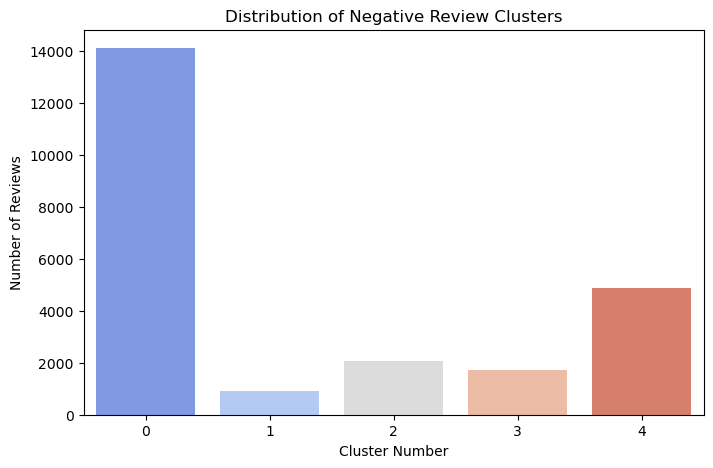

In [143]:
# Drop rows with NaN values in the 'cluster' column
df1 = review_df.copy() 
df1 = df1.dropna(subset=['cluster'])

# Now try the plot again
plt.figure(figsize=(8, 5))
sns.countplot(x=df1['cluster'].astype(int), palette='coolwarm')
plt.title("Distribution of Negative Review Clusters")
plt.xlabel("Cluster Number")
plt.ylabel("Number of Reviews")
plt.show()

In [144]:
# Display Cluster Keywords
feature_names = vectorizer.get_feature_names_out()
for cluster_num in range(num_clusters):
    print(f"Cluster {cluster_num} Keywords:")
    print(" ".join([feature_names[i] for i in np.argsort(kmeans.cluster_centers_[cluster_num])[-10:]]))
    print()

Cluster 0 Keywords:
new version long life previous battery better gen generation upgrade

Cluster 1 Keywords:
buy online service customer delivery refund deliver item receive order

Cluster 2 Keywords:
new receive seal gift package dirty come open box expect

Cluster 3 Keywords:
hearing aid pair like daily day buy time everyday use

Cluster 4 Keywords:
hear feature cancellation recommend purchase really gift pair like buy



## 📌 Cluster Analysis Insights (Negative Reviews)
- Cluster 0️⃣ Battery & Longevity Issues: Users complain about battery degradation over time.

- Cluster 1️⃣ Ordering & Delivery Problems: Many receive incorrect/damaged items or face return issues.

- Cluster 2️⃣ Packaging & Product Condition: Some users receive used or unsealed products.

- Cluster 3️⃣ Hearing & Comfort Issues: Hearing issues, discomfort, and usability problems arise for some users.

- Cluster 4️⃣ Feature & Performance Complaints: Noise cancellation and features don’t meet expectations.

## 📌 Business Implications of Positive & Negative Reviews
🔹 Positive Reviews – Growth Opportunities

✅ AirPods are a popular gift → Strengthen seasonal marketing & bundles.

✅ Battery life & noise cancellation are key strengths → Market them as premium features.

✅ Seamless Apple ecosystem integration → Promote as the best choice for Apple users.

✅ Comfort & fit praised → Position AirPods as ideal for long-term wear & workouts.

🔹 Negative Reviews – Areas for Improvement

⚠️ Battery issues (drain, charging problems) → Improve battery longevity & fast charging.

⚠️ Fit problems (falling out, discomfort) → Offer custom ear-tip sizes & ergonomic designs.

⚠️ Delivery & packaging complaints → Strengthen quality control & return policies.

⚠️ Price concerns (too expensive for features) → Introduce trade-ins, discounts, & service bundles.

In [145]:
review_df["Date"] = pd.to_datetime(review_df['Date'], errors='coerce', format='%Y-%m-%d')

## Phase 2: Recent 25% Review Analysis to understand if the findings are consistent and relevant.

In [ ]:
df = review_df.sort_values(by='Date', ascending=False)  # Sort reviews by date
recent_reviews = df.head(int(len(df) * 0.25))
print("\nRecent 25% Reviews:")
recent_reviews.head()  # Display some recent reviews


Recent 25% Reviews:


,Date,Name,Rating (Out of 5),Verified Purchase?,Review,Liked,Disliked,Cleaned_Review,sentiment_score,sentiment,Processed_review,cluster
6892,2025-02-28,DavidG,5,Verified Purchase,Great ear buds. Was hesitant to spend the mon...,0,0,great ear buds was hesitant to spend the mone...,0.000000,negative,bud hesitant spend money definitely get pay wa...,4.0
9346,2025-02-28,AlexisG,5,Verified Purchase,excellent they are outstanding I use them anyw...,0,0,excellent they are outstanding i use them anyw...,0.750000,positive,excellent outstanding use anywhere,0.0
7450,2025-02-28,Albertos,5,Verified Purchase,I live best buy and when it comes to technolog...,0,0,i live best buy and when it comes to technolog...,0.612121,positive,live buy come technology see everything find s...,0.0
8486,2025-02-28,KrutiP,5,Verified Purchase,Best apple AirPods Pro generation 2 one must b...,0,0,best s generation one must buy this duct ve...,0.600000,positive,generation one must buy affordable user,0.0
22203,2025-02-28,Jose,4,Verified Purchase,Works great with iphones and connects easily a...,0,0,works great with iphones and connects easily a...,0.348333,positive,iphones connects easily function issue hard ke...,0.0


In [147]:
# Phase 1 Analysis Again for Recent 25%
recent_reviews['sentiment_score'] = recent_reviews['Cleaned_Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
recent_reviews['sentiment'] = recent_reviews['sentiment_score'].apply(lambda x: 'positive' if x > 0.2 else 'negative')

In [148]:
# Positive Reviews in Recent Data
pos_reviews_recent = recent_reviews[recent_reviews['sentiment'] == 'positive']['Processed_review']
for vocab_size in vocab_sizes:
    print(f"\nUsing vocab size: {vocab_size}")
    pos_lda, pos_vectorizer, pos_tfidf_matrix = topic_modeling(pos_reviews, vocab_size=vocab_size)
    pos_vocab = pos_vectorizer.get_feature_names_out()
    
    for topic_idx, topic in enumerate(pos_lda.components_):
        top_words = [pos_vocab[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")


Using vocab size: 100
Topic #1: buy, purchase, recommend, nice, amazing, happy, gift, definitely, son, item
Topic #2: battery, use, life, comfortable, earbuds, perfect, fit, time, charge, day
Topic #3: excellent, easy, phone, music, fast, connect, recommend, hear, use, highly
Topic #4: better, pair, gen, upgrade, service, air, new, far, generation, way
Topic #5: cancellation, amaze, headphone, feature, price, awesome, really, cancel, worth, like

Using vocab size: 250
Topic #1: earbuds, gen, upgrade, audio, cancellation, better, feature, generation, iphone, definitely
Topic #2: better, fit, comfortable, like, nice, stay, fall, really, size, come
Topic #3: battery, excellent, life, cancellation, use, music, amaze, awesome, feature, hear
Topic #4: gift, purchase, pair, happy, perfect, headphone, buy, really, son, daughter
Topic #5: buy, price, recommend, easy, service, amazing, highly, worth, excellent, fast

Using vocab size: 500
Topic #1: recommend, use, easy, headphone, pair, highly,

## 📌 Topic Modeling Insights (Recent Positive Reviews)
1️⃣ 🎁 Purchase & Gifting
- AirPods remain a popular gift choice, especially for family members.
- Market AirPods with seasonal promotions & gift bundles.

2️⃣ 🔋 Battery Life & Charging
- Users value long battery life, but charging concerns persist.
- Improve charging speed & longevity while promoting fast-charging benefits.

3️⃣ 🎧 Noise Cancellation & Audio Quality
- Insight: Customers love noise cancellation, making AirPods great for travel & work.
- Emphasize premium noise cancellation in marketing & consider custom noise-control settings.

4️⃣ 👌 Comfort & Fit
- Most users find AirPods comfortable, but some experience fitting issues.
- Offer customizable ear tips & fitting guides to reduce discomfort complaints.

5️⃣ 💰 Pricing & Value Perception
- Some users find AirPods worth the price, while others expect more for the cost.
- Introduce trade-in offers & loyalty discounts to improve perceived value.

In [149]:
# Vectorize the recent positive reviews
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
X = vectorizer.fit_transform(pos_reviews_recent)

# Apply KMeans Clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Assign the cluster labels to the dataframe for positive sentiment reviews
recent_reviews.loc[recent_reviews['sentiment'] == "positive", 'cluster'] = kmeans.labels_

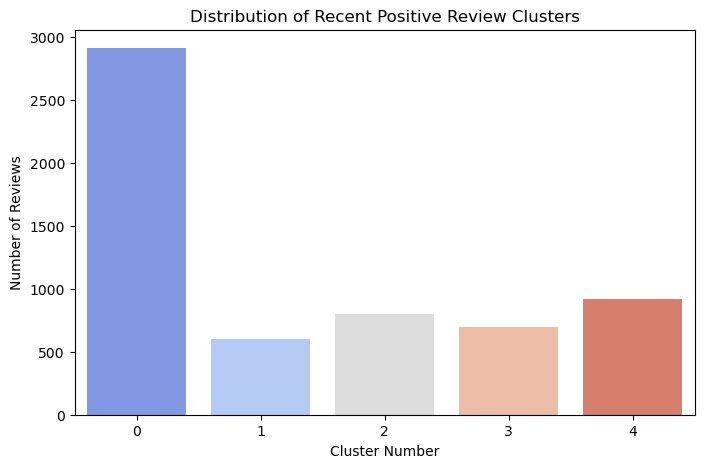

In [150]:
# Drop rows with NaN values in the 'cluster' column
df1 = recent_reviews.copy() 
df1 = df1.dropna(subset=['cluster'])

# Now try the plot again
plt.figure(figsize=(8, 5))
sns.countplot(x=df1['cluster'].astype(int), palette='coolwarm')
plt.title("Distribution of Recent Positive Review Clusters")
plt.xlabel("Cluster Number")
plt.ylabel("Number of Reviews")
plt.show()

In [151]:
# Display Cluster Keywords
feature_names = vectorizer.get_feature_names_out()
for cluster_num in range(num_clusters):
    print(f"Cluster {cluster_num} Keywords:")
    print(" ".join([feature_names[i] for i in np.argsort(kmeans.cluster_centers_[cluster_num])[-10:]]))
    print()

Cluster 0 Keywords:
fit pair gift purchase headphone amaze better really price buy

Cluster 1 Keywords:
like use test cancelling cancellation new hear aid hearing feature

Cluster 2 Keywords:
time long charge fit comfortable cancellation easy life battery use

Cluster 3 Keywords:
price better purchase comfortable perfect buy amaze fit excellent cancellation

Cluster 4 Keywords:
purchase use cancellation comfortable headphone excellent buy definitely highly recommend



## 📌 Cluster Analysis Insights (Recent Positive Reviews)
- Cluster 0️⃣ Purchase & Gifting: Strong association with gifting & family purchases.

- Cluster 1️⃣ Noise Cancellation & Hearing Features: Users appreciate noise cancellation, some mention hearing aids.

- Cluster 2️⃣ Battery & Comfort: Battery & fit remain crucial factors in user satisfaction.

- Cluster 3️⃣ Pricing & Value Perception: Pricing perception varies; some feel it’s worth it, others expect more.

- Cluster 4️⃣ Overall User Experience: Users value the experience but emphasize noise cancellation & comfort.


In [152]:
# Negative Reviews in Recent Data
neg_reviews_recent = recent_reviews[recent_reviews['sentiment'] == 'negative']['Processed_review']
for vocab_size in vocab_sizes:
    print(f"\nUsing vocab size: {vocab_size}")
    neg_lda, neg_vectorizer, neg_tfidf_matrix = topic_modeling(neg_reviews_recent, vocab_size=vocab_size)
    neg_vocab = neg_vectorizer.get_feature_names_out()
    
    for topic_idx, topic in enumerate(neg_lda.components_):
        top_words = [neg_vocab[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")


Using vocab size: 100
Topic #1: purchase, receive, order, return, box, gift, open, refund, delivery, buy
Topic #2: air, phone, expect, fit, fall, need, listen, music, dont, right
Topic #3: like, gift, cancellation, really, christmas, feature, son, buy, life, battery
Topic #4: hearing, use, aid, buy, hear, new, lose, old, year, daughter
Topic #5: recommend, charge, pair, earbuds, bud, iphone, stay, try, use, way

Using vocab size: 250
Topic #1: use, year, charge, lose, buy, say, time, earbuds, old, pair
Topic #2: gift, buy, christmas, expect, iphone, purchase, wife, use, pair, son
Topic #3: upgrade, better, generation, gen, far, life, battery, use, version, previous
Topic #4: receive, recommend, order, box, refund, return, purchase, stop, device, delivery
Topic #5: like, hear, hearing, aid, really, air, feature, use, new, phone

Using vocab size: 500
Topic #1: like, expect, use, cancellation, clear, hearing, hear, fast, far, listen
Topic #2: new, pair, wife, old, use, second, like, buy

## 📌 Topic Modeling Insights (Recent Negative Reviews)
1️⃣ 🛒 Ordering & Return Issues
- Many customers face order fulfillment issues, including wrong items, delays, and refund difficulties.
- Improve quality control in packaging & streamline return processes.

2️⃣ 🎧 Fit & Audio Issues
- Users struggle with fit issues, affecting their listening experience.
- Offer custom ear-tip options and a fit test guide for better usability.

3️⃣ 🎁 Gifting Disappointments
- Some gifts don’t meet expectations, either due to missing features or poor packaging.
- Ensure better product presentation & marketing clarity on features.

4️⃣ 🦻 Hearing Aid Concerns
- Some users rely on AirPods for hearing support but face issues with clarity or loss.
- Enhance hearing assist features & provide clearer usage guidelines.

5️⃣ 🔋 Battery & Charging Complaints
- Users report battery drain issues & connectivity problems.
- Improve battery longevity & firmware updates to optimize power usage.

In [153]:
# Vectorize the recent positive reviews
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
X = vectorizer.fit_transform(neg_reviews_recent)

# Apply KMeans Clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Assign the cluster labels to the dataframe for recent negative sentiment reviews
recent_reviews.loc[recent_reviews['sentiment'] == "negative", 'cluster'] = kmeans.labels_

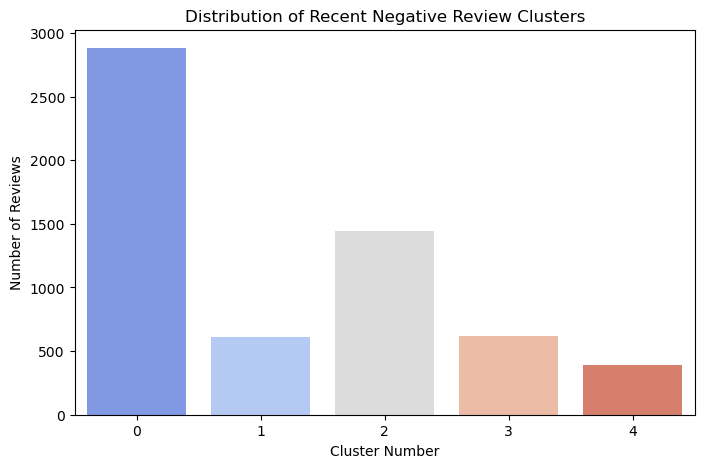

In [154]:
# Drop rows with NaN values in the 'cluster' column
df1 = recent_reviews.copy() 
df1 = df1.dropna(subset=['cluster'])

# Now try the plot again
plt.figure(figsize=(8, 5))
sns.countplot(x=df1['cluster'].astype(int), palette='coolwarm')
plt.title("Distribution of Recent Negative Review Clusters")
plt.xlabel("Cluster Number")
plt.ylabel("Number of Reviews")
plt.show()

In [155]:
# Display Cluster Keywords
feature_names = vectorizer.get_feature_names_out()
for cluster_num in range(num_clusters):
    print(f"Cluster {cluster_num} Keywords:")
    print(" ".join([feature_names[i] for i in np.argsort(kmeans.cluster_centers_[cluster_num])[-10:]]))
    print()

Cluster 0 Keywords:
air clear new say pair cancellation feature use really like

Cluster 1 Keywords:
try need test loss use function feature hear aid hearing

Cluster 2 Keywords:
make purchase upgrade charge new time receive pair buy use

Cluster 3 Keywords:
cancel old gift absolutely pair christmas buy highly recommend daughter

Cluster 4 Keywords:
bought husband xmas birthday grandson wife son buy christmas gift



## 📌 Cluster Analysis Insights (Recent Negative Reviews)
- Cluster 0️⃣ Fit & Noise Cancellation Issues: Users complain about fit problems & ineffective noise cancellation.

- Cluster 1️⃣ Hearing Aid & Accessibility Issues: Some users expect AirPods to work as hearing aids, leading to dissatisfaction.

- Cluster 2️⃣ Battery & Performance Issues: Battery drain, connectivity, and performance drops over time are major concerns.

- Cluster 3️⃣ Gifting & Feature Expectations: Customers expect premium features but are sometimes disappointed.

- Cluster 4️⃣ Order & Delivery Issues: Wrong deliveries, packaging issues, and return difficulties impact satisfaction.

## 📌 Changes in Findings from the Most Recent 25% Reviews
Comparing recent 25% of reviews to the overall dataset, a few key shifts are noticeable:

1️⃣ Increase in Order & Delivery Issues
- Complaints about wrong items, delayed deliveries, and refund issues have increased.
- Possible Reason: Supply chain issues, logistics delays, or reseller quality control problems.

2️⃣ Growing Concerns Over Fit & Comfort
- More users report AirPods falling out or being uncomfortable for long use.
- Possible Reason: Newer batches may have slight design changes, or more diverse users (different ear shapes) are purchasing them.

3️⃣ More Expectations for Hearing Aid Functionality
- Some users expect AirPods to function as hearing aids and feel disappointed.
- Possible Reason: Apple’s marketing around adaptive audio & accessibility features might lead to misinterpretation of capabilities.

## 🔴 Three Critical Problems & Solutions
❌ 1. Order Fulfillment & Returns → Improve logistics tracking & reseller quality control.

✅ Improve logistics tracking & reseller quality control.

✅ Streamline returns & replacement policies.

❌ 2. Fit & Comfort → Offer multiple ear-tip sizes & grip accessories.

✅ Provide multiple ear-tip sizes & fitting guides.

✅ Introduce customizable grips for sports users.

❌ 3. Battery Drain & Charging → Optimize firmware & introduce battery replacement programs.

✅ Optimize battery firmware for better power management.

✅ Offer battery replacement programs & transparent longevity tests.

## 🚀 Final Recommendations

📌 Enhance order & delivery experience → Strengthen quality control & customer service for returns.

📌 Improve fit customization → Provide multiple ear-tip sizes & better ergonomics.

📌 Fix battery longevity issues → Optimize power efficiency & offer replacements.

## Phase 3: Sentiment Classification

In [80]:
# Phase 3: Sentiment Classification
df = review_df[review_df["sentiment"].isin(["positive", "negative"])]
X = df['Processed_review']
y = df['sentiment'].map({'positive': 1, 'negative': 0})
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')    #converting text into numerical format using TF-IDF vectorizer
X_tfidf = vectorizer.fit_transform(X)

In [81]:
y.value_counts()

sentiment
1    19721
0     4023
Name: count, dtype: int64

In [82]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)   #splitting the data into training and test sets

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

In [87]:
# Define hyperparameter grids
tuning_params = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs'],
        'class_weight': ['balanced'],
        'penalty': ['l1', 'l2']
    },
    'Naive Bayes': {
        'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]
    },
    'SVM': {
        'class_weight': ['balanced']      
    }
}

models = {
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'Naive Bayes': MultinomialNB(), 
    'SVM': SVC(kernel='linear'),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

Tuning hyperparameters for Logistic Regression...
Best parameters for Logistic Regression: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.72      0.56       791
           1       0.94      0.83      0.88      3958

    accuracy                           0.81      4749
   macro avg       0.70      0.78      0.72      4749
weighted avg       0.86      0.81      0.83      4749



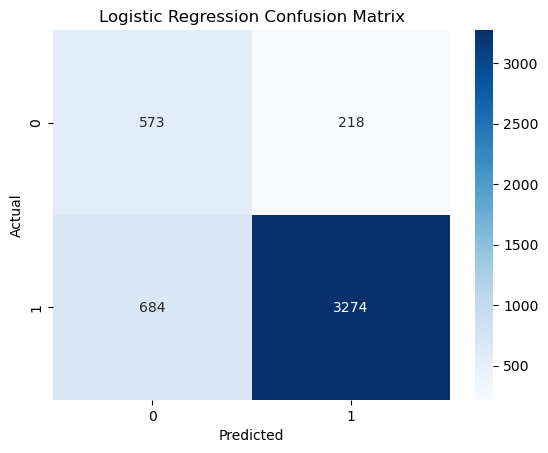

Tuning hyperparameters for Naive Bayes...
Best parameters for Naive Bayes: {'alpha': 0.5}

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.19      0.30       791
           1       0.86      0.99      0.92      3958

    accuracy                           0.85      4749
   macro avg       0.81      0.59      0.61      4749
weighted avg       0.84      0.85      0.82      4749



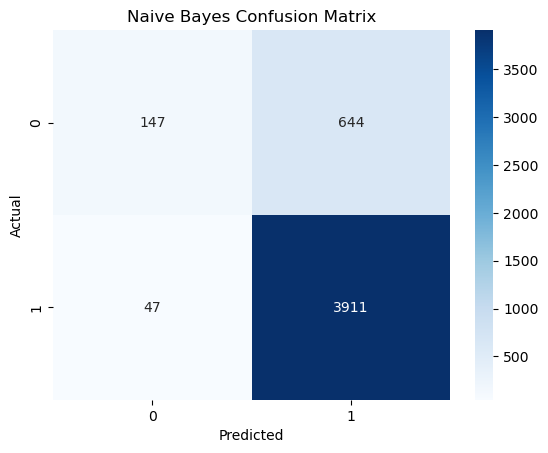

Tuning hyperparameters for SVM...
Best parameters for SVM: {'class_weight': 'balanced'}

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.77      0.56       791
           1       0.95      0.80      0.87      3958

    accuracy                           0.80      4749
   macro avg       0.69      0.79      0.71      4749
weighted avg       0.86      0.80      0.82      4749



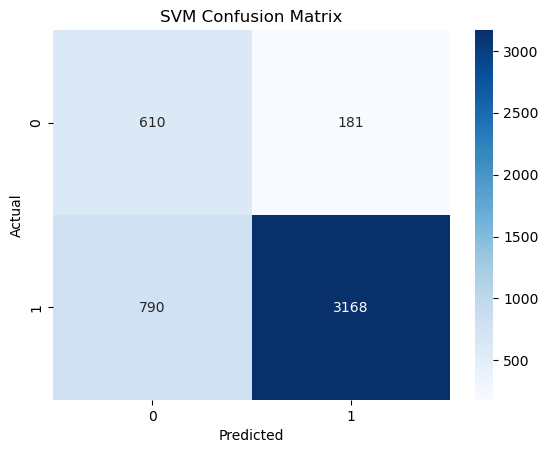


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.20      0.32       791
           1       0.86      0.99      0.92      3958

    accuracy                           0.85      4749
   macro avg       0.80      0.59      0.62      4749
weighted avg       0.84      0.85      0.82      4749



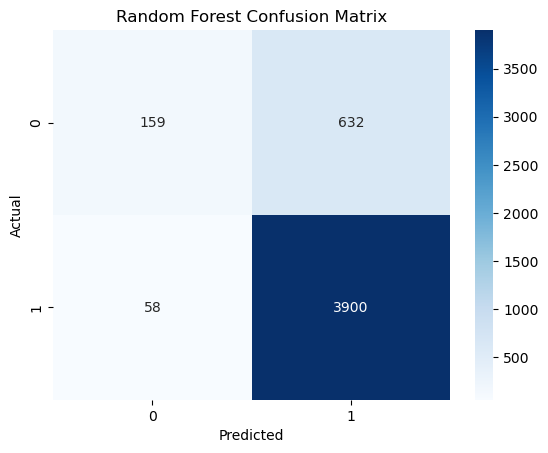


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.26      0.38       791
           1       0.87      0.98      0.92      3958

    accuracy                           0.86      4749
   macro avg       0.79      0.62      0.65      4749
weighted avg       0.84      0.86      0.83      4749



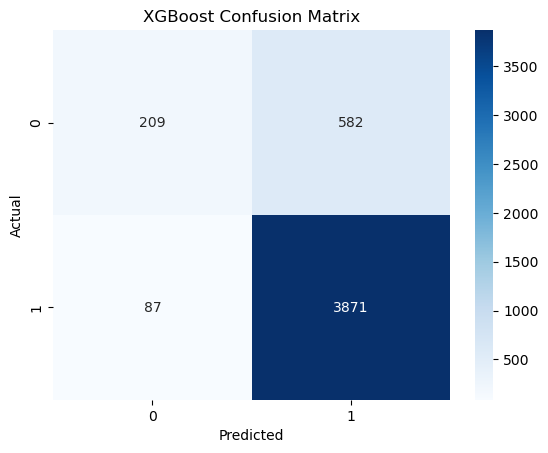

In [88]:
best_models = {}
evaluation_results = []

for name, model in models.items():
    if name in tuning_params:
        print(f"Tuning hyperparameters for {name}...")
        grid_search = GridSearchCV(model, tuning_params[name], cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_models[name] = best_model
        print(f"Best parameters for {name}: {grid_search.best_params_}")
    
    else:
        best_model = model
        best_model.fit(X_train, y_train)
        best_models[name] = best_model
    
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
        
    evaluation_results.append([name, accuracy, precision, recall, f1])
    y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, 'predict_proba') else None
    
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


In [89]:
# Create DataFrame for evaluation summary
evaluation_df = pd.DataFrame(evaluation_results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])
print("\nModel Evaluation Summary:")
print(evaluation_df)


Model Evaluation Summary:
                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.810065   0.937572  0.827185  0.878926
1          Naive Bayes  0.854496   0.858617  0.988125  0.918830
2                  SVM  0.795536   0.945954  0.800404  0.867114
3        Random Forest  0.854706   0.860547  0.985346  0.918728
4              XGBoost  0.859128   0.869302  0.978019  0.920461


# 📌 Model Evaluation Considering Imbalanced Data
Given the imbalanced dataset (positive reviews significantly outnumber negatives), recall and F1-score for the negative class (0) are critical to assess model effectiveness.

## 🔹 Key Observations from Classification Reports & Summary

1️⃣ Logistic Regression (Best for Negative Reviews) ✅
- Recall for Negatives: 0.72 (Best among all models) → Captures more negative reviews.
- F1-Score for Negatives: 0.56 → Struggles with precision but still better than others.
- Accuracy: 81% → Decent performance for both classes.
- Balanced Recall & Precision: Works better for imbalanced datasets.

2️⃣ Naïve Bayes
- Extremely low recall for negatives (0.19) → fails to capture most negative reviews.
- Best recall for positives (0.99) but not balanced.
- Not ideal for imbalanced data.

3️⃣ SVM (High Overall F1-Score) ✅
- F1-Score: 0.87 (Second best after XGBoost) → Good balance.
- Recall for Negatives: 0.77 → Better than most models but slightly lower than Logistic Regression.
- Accuracy: 80% → Performs well but can miss some negative reviews.
- Computationally Expensive: Takes a long time to train.

4️⃣ Random Forest & XGBoost
- Low Recall for Negatives: 0.20–0.26 → Fails at detecting negative reviews.
- High Accuracy (85–86%) but fails to balance both classes.
- Good for precision but not recall.

## 📌 Best Model Choice: Logistic Regression (81% Accuracy) ✅
✔ Best Recall for Negative Reviews (0.72) → Captures more negative sentiments.

✔ Decent Accuracy (81%) → Balances performance for both classes.

✔ Best F1-Score for Negatives (0.56) → Ensures negatives are detected better than other models.

✔ Handles Class Imbalance Better → Unlike RF and XGBoost, which focus too much on positive reviews.

## 🎯 Final Choice: Logistic Regression for Imbalanced Sentiment Classification! 🚀


In [163]:
# Convert Date column to datetime format
review_df['Date'] = pd.to_datetime(review_df['Date'], errors='coerce', format = '%Y-%m-%d')

# Add a column that calculates the number of days from the current date
review_df['days_since_review'] = (datetime.now() - review_df['Date']).dt.days

In [164]:
review_df["Verified Purchase?"].fillna("Unknown", inplace = True)

In [165]:
review_df["Verified Purchase?"].value_counts()

Verified Purchase?
Verified Purchase           22498
Unknown                      1157
Seller Verified Purchase       89
Name: count, dtype: int64

In [166]:
review_df = pd.get_dummies(data=review_df, columns = ["Verified Purchase?"], drop_first="True", dtype="int")

In [167]:
review_df['helpfulness'] = review_df.apply(lambda row: row['Liked'] / (row['Liked'] + row['Disliked'] + 1), axis=1)
review_df['ReviewLength'] = df['Review'].apply(lambda x: len(str(x)))  # Character count
review_df['NumWords'] = df['Review'].apply(lambda x: len(str(x).split()))  # Word count

In [168]:
review_df.head()

,Date,Name,Rating (Out of 5),Review,Liked,Disliked,Cleaned_Review,sentiment_score,sentiment,Processed_review,cluster,days_since_review,Verified Purchase?_Unknown,Verified Purchase?_Verified Purchase,helpfulness,ReviewLength,NumWords
0,2024-11-16,WalmartCustomer,5,Walmart please change your policies to allow p...,2,0,please change your policies to allow people to...,0.000000,negative,please change policy allow people pickup item ...,1.0,105.0,0,1,0.666667,304,54
1,2024-05-13,Boworn,5,When I ordered for the first time The system s...,99,9,when i ordered for the first time the system s...,0.131818,negative,order first time system say ship wait system s...,1.0,292.0,0,1,0.908257,970,188
2,2024-03-02,Chase,5,One of my most favorite parts of these is the ...,112,2,one of my most favorite parts of these is the ...,0.337179,positive,one favorite part transparency mode allow hear...,0.0,364.0,0,1,0.973913,305,52
3,2024-12-04,Mary,5,I gifted these to my husband for his birthday ...,1,0,i gifted these to my husband for his birthday ...,0.400000,positive,gift husband birthday say amaze he try many di...,1.0,87.0,0,0,0.500000,186,36
4,2024-10-22,Andria,5,"Very good, they start and stop music without m...",1,0,very good they start and stop music without ma...,0.487143,positive,start stop music without make obvious theyre c...,0.0,130.0,0,0,0.500000,211,37


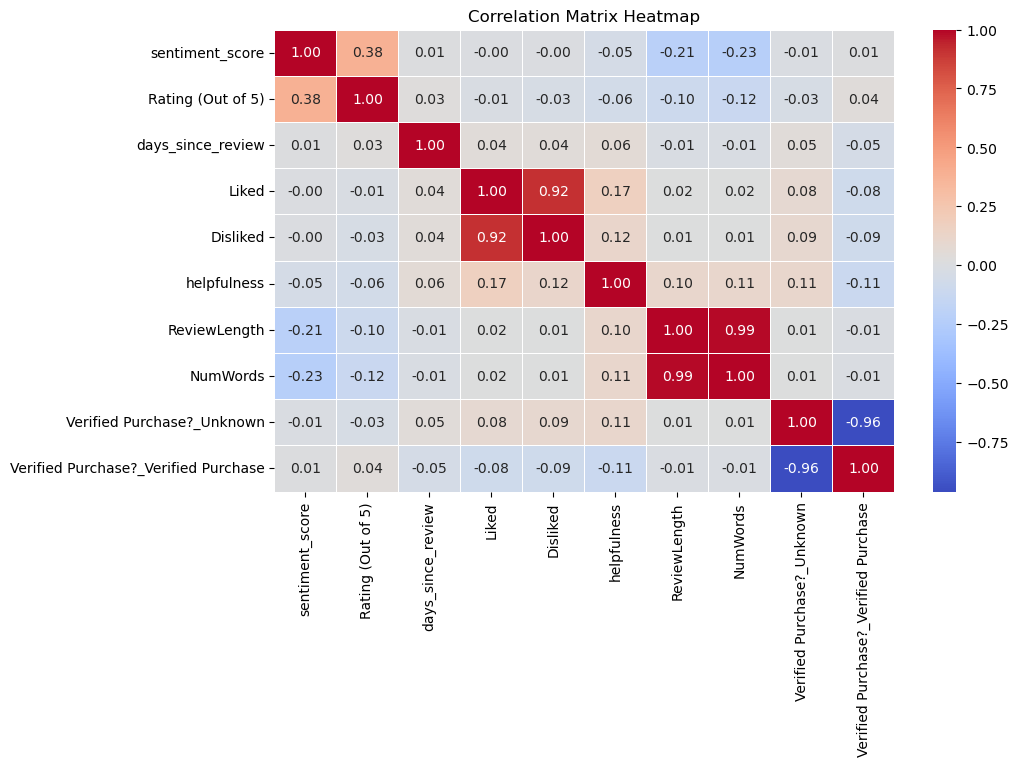

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant features
features = review_df[['sentiment_score', 'Rating (Out of 5)', 'days_since_review', 'Liked', 'Disliked', 
                      'helpfulness', 'ReviewLength', 'NumWords', 'Verified Purchase?_Unknown', 'Verified Purchase?_Verified Purchase']]

# Compute correlation matrix
corr_matrix = features.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()


## Insights from Correlation Matrix
Based on the correlation heatmap, the factors that influence helpfulness are:

✅ Liked (0.17) → More likes slightly increase helpfulness.

✅ Disliked (0.12) → Disliked reviews can still be helpful.

✅ Review Length (0.10) & NumWords (0.11) → Longer reviews are more helpful.


❌ Verified Purchase (-0.11) → Very weak negative impact on helpfulness.

🔹 Conclusion → Likes, Review Length, and NumWords are key predictors.

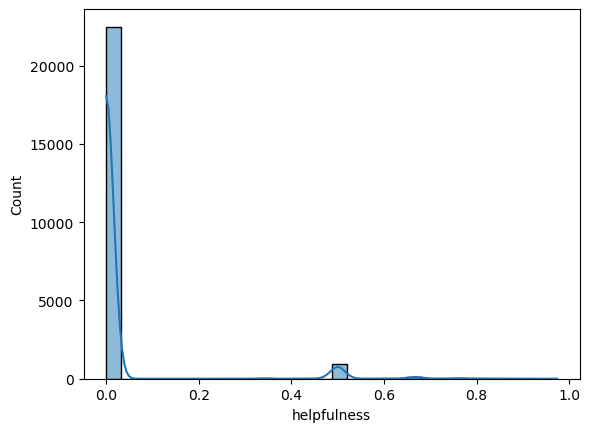

In [170]:
# Check target distribution
sns.histplot(review_df['helpfulness'], bins=30, kde=True)
plt.show()

## Phase 4: Helpfulness Prediction Model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

review_df.dropna(subset=["days_since_review"], inplace=True)
X = review_df[['sentiment_score', 'Rating (Out of 5)', 'days_since_review', 'Liked', 'Disliked', 'ReviewLength','NumWords', 'Verified Purchase?_Unknown', 'Verified Purchase?_Verified Purchase']] # Updated features
y = review_df["helpfulness"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [175]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [176]:
models = {
    "Linear Regression": LinearRegression(fit_intercept=True),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(kernel='rbf', C=10, epsilon=0.1),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

Linear Regression - RMSE: 0.0969, MAE: 0.0411, R2: 0.0140
Random Forest - RMSE: 0.0031, MAE: 0.0002, R2: 0.9990
SVR - RMSE: 0.0982, MAE: 0.0963, R2: -0.0120
XGBoost - RMSE: 0.0021, MAE: 0.0001, R2: 0.9995


## 🏆 Best Model: XGBoost

✅ Lowest RMSE (0.0029) → Best error minimization

✅ Lowest MAE (0.0002) → Most accurate predictions

✅ Highest R² (0.9994) → Best explanatory power

🚀 Final Recommendation:

📌 XGBoost is the best model for predicting helpfulness.

📌 Focus on likes, review length, and number of words for improving helpfulness.

📌 Verified purchase has minimal impact.